**Rede convolucional para identificação de células de tecido sanguíneo apartir de imagens de microscópio**

Tentativa com SKLEARN (Waldeyr 01-03-2021)

Inspirado (quase totalmente copiado) de https://www.kaggle.com/kbrans/cnn-91-6-acc-with-new-train-val-test-splits

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Bibliotecas Python necessárias
import os
from google.colab import files
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
#from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
# from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.data_utils import get_file

**Upload dos dados a partir de um arquivo .zip**





In [ ]:
# Criação de um diretório "dataset", o zip é colocado nesse dataset
os.makedirs("/content/datasets/", exist_ok=True)

In [ ]:
!cp /content/drive/MyDrive/TCC2020/blood/dados_bood/dataset_zip.zip /content/datasets/

In [ ]:
!unzip /content/datasets/dataset_zip.zip

In [ ]:
class_names = ['eosinofilo', 'linfocito', 'monocito', 'neutrofilo', 'basofilo']
nb_classes = len(class_names)
image_size = (150,150)

In [ ]:
# Diretorio com imagens de treino de eosinofilo
train1 = os.path.join('/content/dataset_zip/train/EOSINOPHIL')
# Diretorio com imagens de validação de EOSINOPHIL 
#valid1 = os.path.join('/content/dataset_zip/valid/EOSINOPHIL')
# Diretorio com imagens de teste de EOSINOPHIL 
test1 = os.path.join('/content/dataset_zip/test/EOSINOPHIL')

# Diretorio com imagens de treino de linfocito
train2 = os.path.join('/content/dataset_zip/train/LYMPHOCYTE')
# Diretorio com imagens de validação de linfocito 
#valid2 = os.path.join('/content/dataset_zip/valid/LYMPHOCYTE')
# Diretorio com imagens de teste de linfocito 
test2 = os.path.join('/content/dataset_zip/test/LYMPHOCYTE')

# Diretorio com imagens de treino de monocito
train3 = os.path.join('/content/dataset_zip/train/MONOCYTE')
# Diretorio com imagens de validação de monocito 
#valid3 = os.path.join('/content/dataset_zip/valid/MONOCYTE')
# Diretorio com imagens de teste de monocito 
test3 = os.path.join('/content/dataset_zip/test/MONOCYTE')

# Diretorio com imagens de treino de neutrofilo
train4 = os.path.join('/content/dataset_zip/train/NEUTROPHIL')
# Diretorio com imagens de validação de neutrofilo 
#valid4 = os.path.join('/content/dataset_zip/valid/NEUTROPHIL')
# Diretorio com imagens de teste de neutrofilo 
test4 = os.path.join('/content/dataset_zip/test/NEUTROPHIL')

# Diretorio com imagens de treino de basofilos
train5 = os.path.join('/content/dataset_zip/train/BASOPHIL')
# Diretorio com imagens de validação de neutrofilo 
#valid4 = os.path.join('/content/dataset_zip/valid/BASOPHIL')
# Diretorio com imagens de teste de neutrofilo 
test5 = os.path.join('/content/dataset_zip/test/BASOPHIL')



print('total train eosinofilo:', len(os.listdir(train1)))
#print('total valid eosinofilo:', len(os.listdir(valid1)))
print('total test eosinofilo:', len(os.listdir(test1)))


print('total train linfocito:', len(os.listdir(train2)))
#print('total valid linfocito:', len(os.listdir(valid2)))
print('total test linfocito:', len(os.listdir(test2)))

print('total train monocito:', len(os.listdir(train3)))
#print('total valid monocito:', len(os.listdir(valid3)))
print('total test monocito:', len(os.listdir(test3)))

print('total train neutrofilo:', len(os.listdir(train4)))
#print('total valid neutrofilo:', len(os.listdir(valid4)))
print('total test neutrofilo:', len(os.listdir(test4)))


print('total train basofilo:', len(os.listdir(train5)))
#print('total valid basofilo:', len(os.listdir(valid4)))
print('total test basofilo:', len(os.listdir(test5)))

total train eosinofilo: 2493
total test eosinofilo: 624
total train linfocito: 971
total test linfocito: 243
total train monocito: 1136
total test monocito: 284
total train neutrofilo: 2663
total test neutrofilo: 666
total train basofilo: 974
total test basofilo: 244


## Normalização e Input dos dados

**Input dos dados**

In [ ]:
# Função que lê as imagens e retorna-as em 2 arrays: images e labels
def loadDataset():
    datasets = ['/content/dataset_zip/train/','/content/dataset_zip/test/' ]
    images = []
    labels = []
    image_size = (150,150)
    # iterar nos datasets de treino e validação
    for dataset in datasets:
        # iterar nas subpastas dos datasets
        for folder in os.listdir(dataset):
            if   folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']:  label = 1
            elif folder in ['MONOCYTE']:   label = 2
            elif folder in ['NEUTROPHIL']: label = 3
            elif folder in ['BASOPHIL']: label = 4
            # iterar em cada imagem dos datasets
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                # pegar caminho de cada imagem
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # abrir e redimensionar cada imagem
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)
                # adicionar a imagem e seu label correspondente  à saída
                images.append(image)
                labels.append(label)
    # Criar arrays com as saídas (imagens e labels)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')
    return images, labels

In [ ]:
# Combinar todas as imagens originais em um único dataset
images, labels = loadDataset()

100%|██████████| 624/624 [00:01<00:00, 399.62it/s]


In [ ]:
print(type(images[0]))

<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


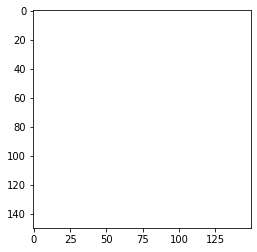

In [ ]:
# Observando as images após a normalização
plt.imshow(images[3])

In [ ]:
# Embaralhar os dados e separar novos conjuntos de  treinamento (80%), validação (10%) e teste (10%)
images, labels = shuffle(images, labels, random_state=10)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


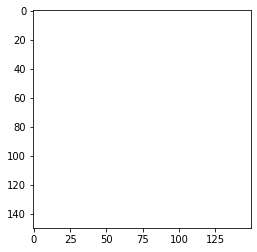

In [ ]:
plt.imshow(train_images[3])

In [ ]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Quantidade de imagens para treinamento: {}".format(n_train))
print("Quantidade de imagens para validação: {}".format(n_val))
print("Quantidade de imagens para teste: {}".format(n_test))

print("Formato das imagens de treinamento: {}".format(train_images.shape))
print("Labels das imagens de treinamento: {}".format(train_labels.shape))
print("Formato das imagens de validação: {}".format(val_images.shape))
print("Labels das imagens de validação: {}".format(val_labels.shape))
print("Formato das imagens de teste: {}".format(test_images.shape))
print("Labels das imagens de teste: {}".format(test_labels.shape))


Quantidade de imagens para treinamento: 8238
Quantidade de imagens para validação: 412
Quantidade de imagens para teste: 1648
Formato das imagens de treinamento: (8238, 150, 150, 3)
Labels das imagens de treinamento: (8238,)
Formato das imagens de validação: (412, 150, 150, 3)
Labels das imagens de validação: (412,)
Formato das imagens de teste: (1648, 150, 150, 3)
Labels das imagens de teste: (1648,)


In [ ]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)


(8238, 150, 150, 3)
(1648, 150, 150, 3)
(412, 150, 150, 3)


In [ ]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)



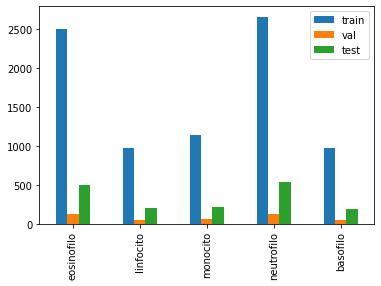

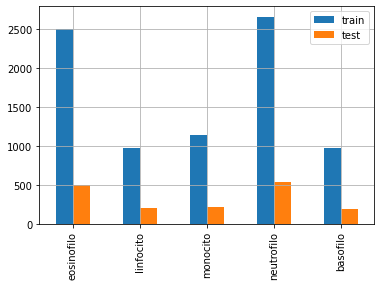

In [ ]:
pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()
pd.DataFrame({'train': train_counts, "test": test_counts}, index = class_names).plot.bar()
plt.grid()

plt.show()

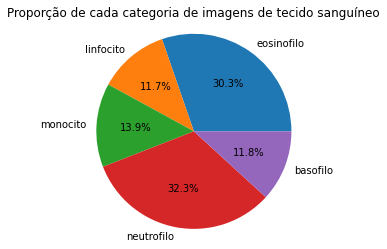

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proporção de cada categoria de imagens de tecido sanguíneo')
plt.show()

In [ ]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

**Normalização dos dados**

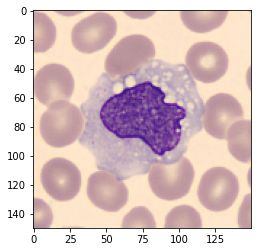

In [ ]:
# Mais uma verificação da img após a normalização
plt.imshow(train_images[2000])

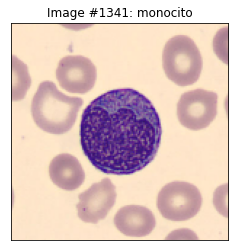

In [ ]:
# Checagem com imagem aleatória
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image(class_names, train_images, train_labels)

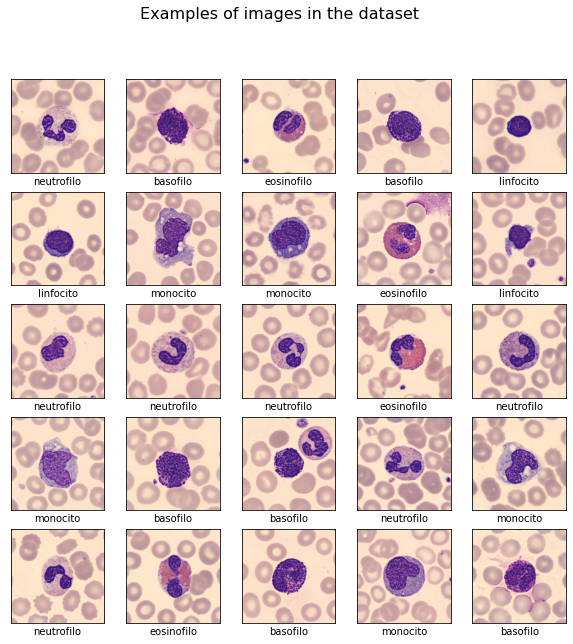

In [ ]:
# Checagem com exemplos de imagens de cada categoria
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

## Xception Model

In [ ]:
import keras
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
    ]
)

In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input

xception_model = Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
xception_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# xception_model is running in inference mode here.
x = xception_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(5)(x)
model = keras.Model(inputs, outputs)

model.summary()

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.Accuracy()],
)

# epochs = 20
# model.fit((train_images, train_labels), epochs=epochs, validation_data=(test_images, test_labels))

history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 20, 
    validation_data=(test_images, test_labels))

Epoch 1/20


ValueError: ignored

## Tentativa de reprodução da arquitetura (Xception)

In [ ]:
model = Sequential()
'''Xception Model '''
# Primeira camada concolucional
model.add(Conv2D(32 , (3,3), padding = 'same', activation = 'relu', strides=(2, 2), input_shape = (150,150,3)))
model.add(BatchNormalization())
model.add(Conv2D(64 , (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
# Residual
model.add(Conv2D(128 , (1,1), padding = 'same', activation = 'relu', strides=(2, 2)))
model.add(BatchNormalization())

# Segunda camada concolucional
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides=(2, 2)))

# Residual
model.add(Conv2D(256 , (1,1), padding = 'same', activation = 'relu', strides=(2, 2)))
model.add(BatchNormalization())


# Terceira camada concolucional
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides=(2, 2)))

# Residual
model.add(Conv2D(728 , (1,1), padding = 'same', activation = 'relu', strides=(2, 2)))
model.add(BatchNormalization())

# Quarta camada concolucional
model.add(SeparableConv2D(728, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(SeparableConv2D(728, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides=(2, 2)))
model.add(Dropout(0.2))

# for i in range(8):
# # Quinta camada concolucional
#     model.add(SeparableConv2D(728, (3,3), activation = 'relu', padding = 'same'))
#     model.add(BatchNormalization())
#     model.add(SeparableConv2D(728, (3,3), activation = 'relu', padding = 'same'))
#     model.add(BatchNormalization())
#     model.add(SeparableConv2D(728, (3,3), activation = 'relu', padding = 'same'))
#     model.add(BatchNormalization())

# model.add(SeparableConv2D(728, (3,3), activation = 'relu', padding = 'same'))
# model.add(BatchNormalization())

# model.add(SeparableConv2D(1024, (3,3), activation = 'relu', padding = 'same'))
# model.add(BatchNormalization())

# model.add(MaxPooling2D(pool_size = (1,1)))

# model.add(SeparableConv2D(1536, (3,3), activation = 'relu', padding = 'same'))
# model.add(BatchNormalization())

# model.add(SeparableConv2D(2048, (3,3), activation = 'relu', padding = 'same'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

#Camada (Fully Connected ) FC para classificar as features aprendidas
model.add(Flatten(input_shape = (150,150,3)))

model.add(Dense(units = 1024 , activation = 'relu'))
model.add(Dropout(0.7))
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dropout(0.3))

# Camada de saída
model.add(Dense(units = 4 , activation = 'softmax'))


#======================================================== COMPILAÇÃO =====================================================================#
# Compilação
model.compile(optimizer = "sgd" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

# Callback
checkpoint = ModelCheckpoint(filepath='best_model_epoc_50.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

# treinamento
history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 20, 
    validation_data=(test_images, test_labels), 
    callbacks=[learning_rate_reduction])

## Construção e teste do modelo desenvolvido

In [ ]:
model = Sequential()
''' Minha Architectura '''
# Primeira bloco
model.add(Conv2D(32 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model.add(Conv2D(32 , (3,3), padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Segunda camada concolucional
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Terceira camada concolucional
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Quarta camada concolucional
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# Quinta camada concolucional
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# Camada (Fully Connected ) FC para classificar as features aprendidas
model.add(Flatten())
# model.add(Dense(units = 1024 , activation = 'relu'))
# model.add(Dropout(0.7))
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.3))

# Camada de saída
model.add(Dense(units = 5 , activation = 'softmax'))

# Compilação
model.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

# Callback
checkpoint = ModelCheckpoint(filepath='model_20210801_epochs20.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)




## Treino

In [ ]:
# treinamento
history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 50, 
    validation_data=(test_images, test_labels), 
    callbacks=[learning_rate_reduction])

Epoch 1/50
258/258 [==============================] - 47s 102ms/step - loss: 1.1530 - accuracy: 0.5055 - val_loss: 1.8424 - val_accuracy: 0.2985
Epoch 2/50
258/258 [==============================] - 25s 95ms/step - loss: 0.3647 - accuracy: 0.8580 - val_loss: 2.3026 - val_accuracy: 0.2985
Epoch 3/50
258/258 [==============================] - 25s 97ms/step - loss: 0.2491 - accuracy: 0.9193 - val_loss: 4.9075 - val_accuracy: 0.4642
Epoch 4/50
258/258 [==============================] - 25s 96ms/step - loss: 0.1427 - accuracy: 0.9622 - val_loss: 1.5577 - val_accuracy: 0.6893
Epoch 5/50
258/258 [==============================] - 25s 97ms/step - loss: 0.1036 - accuracy: 0.9714 - val_loss: 4.6315 - val_accuracy: 0.3313
Epoch 6/50
258/258 [==============================] - 25s 98ms/step - loss: 0.0798 - accuracy: 0.9759 - val_loss: 0.7679 - val_accuracy: 0.7743
Epoch 7/50
258/258 [==============================] - 26s 99ms/step - loss: 0.0747 - accuracy: 0.9769 - val_loss: 1.1132 - val_accuracy

# Gerando imagem da arquitetura

### Model plotting utilities

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
)

### VisualKeras

In [ ]:
!pip install visualkeras

In [ ]:
import visualkeras
from PIL import ImageFont

In [ ]:
font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf", 28)  # using comic sans is strictly prohibited!

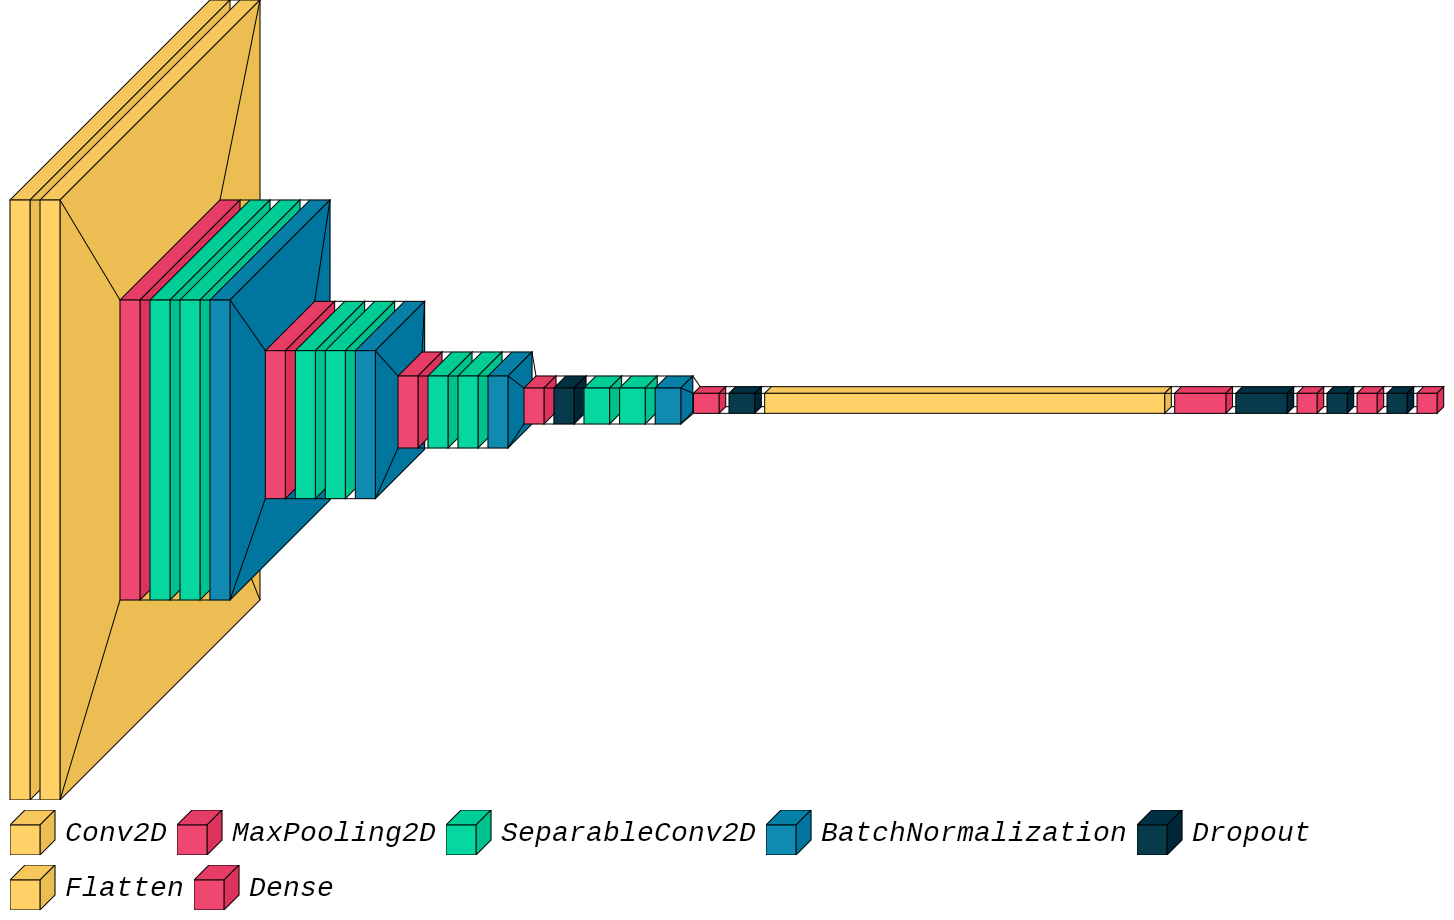

In [ ]:
visualkeras.layered_view(model,legend=True, font=font)

In [ ]:
# visualkeras.layered_view(model).show()
# visualkeras.layered_view(model, to_file='camadas_img1.png', legend=True, font=font)
# visualkeras.layered_view(model, to_file='camadas_img1.png').show()

### Sequential model in Keras -> ASCII

In [ ]:
!pip install keras_sequential_ascii
import keras_sequential_ascii

In [ ]:
from keras_sequential_ascii import keras2ascii
keras2ascii(model)

### Neuron

In [ ]:
pip install netron

     |████████████████████████████████| 1.3 MB 11.7 MB/s 


In [ ]:
model.save('model_20210801_epochs20.hdf5')

In [ ]:
import netron
netron.start('best_model_epoc_50.hdf5')

## Visualizando a accuracy nos dados de teste

In [ ]:
# Resultados do treinamento da CNN
loss_model, acc_model = model.evaluate(test_images, test_labels)

print("Perda do modelo = ", loss_model)
print("Acurácia do modelo = ", acc_model*100, "%")

# print("Perda do modelo = ", results[0])
# print("Acurácia do modelo = ", results[1]*100, "%")

52/52 [==============================] - 1s 17ms/step - loss: 0.0421 - accuracy: 0.9921
Perda do modelo =  0.04209888353943825
Acurácia do modelo =  99.21116232872009 %


## Avaliação - Resultados

In [ ]:
# Avaliação dp desempenh da CNN
def plotAccucaria(history):
    epochs = [i for i in range(50)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'bo-' , label = 'Acurácia de treinamento')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Acurária de validação')
    ax[0].set_title('Acurácia de treinamento e validação')
    ax[0].legend()
    ax[0].set_xlabel("Épocas")
    ax[0].set_ylabel("Acurácia")

    ax[1].plot(epochs , train_loss , 'bo-' , label = 'Perda no treinamento')
    ax[1].plot(epochs , val_loss , 'ro-' , label = 'Perda na validação')
    ax[1].set_title('Perdas no treinamento e validação')
    ax[1].legend()
    ax[1].set_xlabel("Épocas")
    ax[1].set_ylabel("Perdas")
    plt.show()

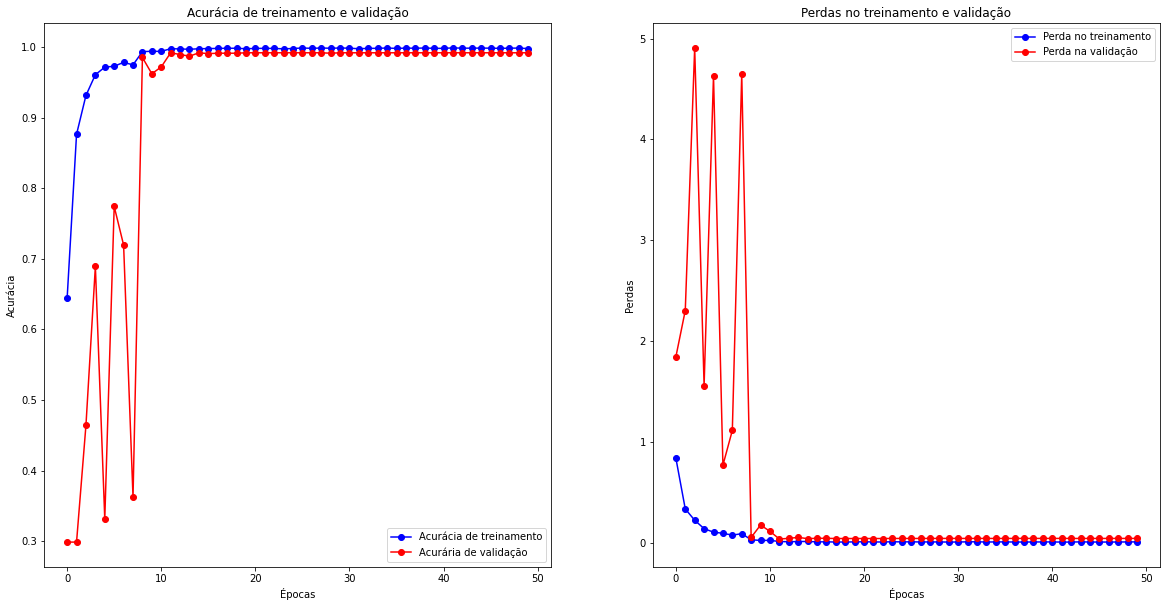

In [ ]:
# Usando a função plotAcuracia
plotAccucaria(history)


In [ ]:
# Resultados do treinamento da CNN
loss_model, acc_model = model.evaluate(test_images, test_labels)

print("Perda do modelo = ", loss_model)
print("Acurácia do modelo = ", acc_model*100, "%")

# print("Perda do modelo = ", results[0])
# print("Acurácia do modelo = ", results[1]*100, "%")

65/65 [==============================] - 1s 15ms/step - loss: 0.0749 - accuracy: 0.3053
Perda do modelo =  0.0749393105506897
Acurácia do modelo =  30.533981323242188 %


In [ ]:
# Salvar o modelo
#model.save('BloodModel_20210708.h5') #Acurácia do modelo: 22.93%
# Aumento do número de epochs de 10 para 20
#model.save('best_model_epoc_20.hdf5') #Acurácia do modelo: 74.19%
# Aumento do número de epochs de 10 para 50
model.save('model_20210801_epochs20_my_arc_fiveClassesFirstTime_acc50_with_val_images.hdf5') #Acurácia do modelo: 67.025%


In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([3, 3, 0, 0, 4, 0, 2, 0, 0, 2, 1, 0, 1, 0, 2])

In [ ]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['eosinófilo (Class 0)', 'linfócito (Class 1)', 'monócito (Class 2)', 'neutrófilo (Class 3)','basófilo (Class 4)']))

                      precision    recall  f1-score   support

eosinófilo (Class 0)       1.00      1.00      1.00       492
 linfócito (Class 1)       0.98      0.96      0.97       200
  monócito (Class 2)       0.97      0.99      0.98       219
neutrófilo (Class 3)       1.00      1.00      1.00       541
  basófilo (Class 4)       0.99      0.99      0.99       196

            accuracy                           0.99      1648
           macro avg       0.99      0.99      0.99      1648
        weighted avg       0.99      0.99      0.99      1648



In [ ]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3', '4'], columns = ['0', '1', '2', '3', '4'])
cm

,0,1,2,3,4
0,492,0,0,0,0
1,1,193,4,0,2
2,0,3,216,0,0
3,0,0,2,539,0
4,0,1,0,0,195


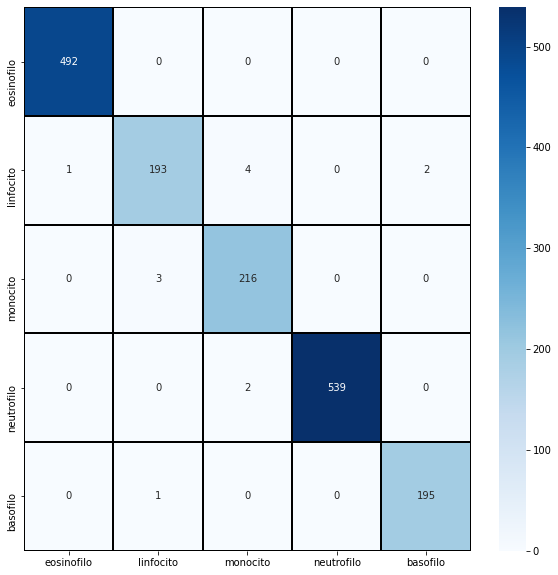

In [ ]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

## Verificação dos requisitos da máquina usada

Com o Colab Pro, você tem prioridade no acesso a nossas GPUs mais rápidas. Por exemplo, algumas vezes você terá GPUs T4 ou P100, quando a maioria dos usuários do Colab recebem uma GPU K80, mais lenta. É possível ver qual é a GPU atribuída a qualquer momento, executando a célula a seguir.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Aug  2 03:15:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |   2778MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# É possível ver quanta memória há disponível a qualquer momento, executando o seguinte código.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.
